In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import riskkit as erk
import scipy.stats as stats
import exp
import multiprocessing as mp
import itertools
import os
import pickle
from scipy.stats.mstats import gmean

 6 games: max = 1.84 at 0.30
 7 games: max = 2.29 at 0.34
 8 games: max = 2.25 at 0.30
 9 games: max = 2.79 at 0.33
10 games: max = 2.76 at 0.30


<AxesSubplot:>

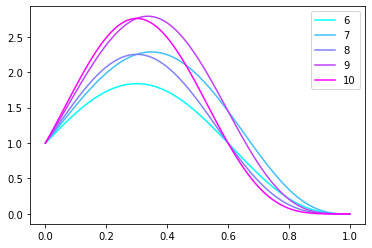

In [2]:
fractions = np.linspace(0, 1, 100)
data = {}
for n_games in range(6, 11):
    medians = np.array([exp.play_games(f, n_games, 3.5).median() for f in fractions])
    data[str(n_games)] = medians
    print('{: >2d} games: max = {:.2f} at {:.2f}'.format(n_games, medians.max(), fractions[medians.argmax()]))
df = pd.DataFrame(data, fractions)
df.plot(cmap='cool')

<AxesSubplot:>

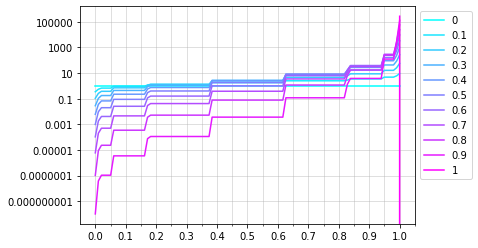

In [3]:
games = {exp.fformat(f): exp.play_games(f, 10, 3.5) for f in np.linspace(0, 1, 11)}
quantiles = exp.game_quantiles(games)
exp.plot_quantile(quantiles)

count    256.000000
mean      12.776785
std       48.209120
min        0.003906
25%        0.355957
50%        1.601807
75%        7.208130
max      656.840836
dtype: float64


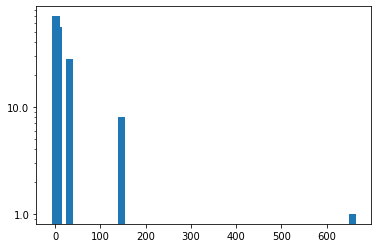

In [4]:
games = exp.play_games(.5, 8, 3.5)
print(games.describe())
exp.plot_histogram(games, proportional=True)

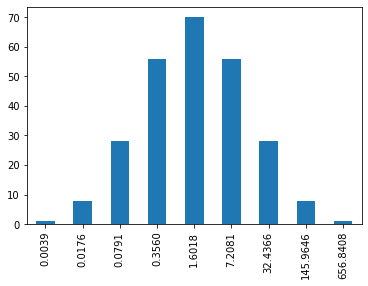

In [5]:
exp.plot_histogram(games, proportional=False)

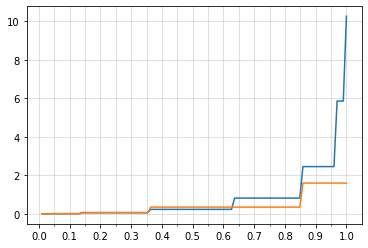

In [6]:
qs = np.linspace(0, 1, 100)
means = [games[games < games.quantile(q)].mean() for q in qs]
medians = [games[games < games.quantile(q)].median() for q in qs]

fig, ax = plt.subplots()
ax.plot(qs, means)
ax.plot(qs, medians)
ax.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.grid(b=True, which='both', alpha=.5)

In [7]:
np.array([np.random.uniform() < .5 for i in range(100000)]).mean()

0.49897

In [8]:
f = .3
length = 10
stop = lambda i, v: i >= length
n = 50

games = [exp.play_game(f, stop, series=False) for i in range(n)]
print('\nSimulating')
print(pd.Series(games).describe())

print('\nAll scenarios')
print(exp.play_games(f, 10).describe())


Simulating
count                                              50
unique                                             19
top       {'value': 0.5200681398062498, 'length': 11}
freq                                                7
dtype: object

All scenarios
count    1024.000000
mean        2.061032
std         3.025623
min         0.028248
25%         0.520068
50%         1.077284
75%         2.231517
max        41.084691
dtype: float64


2.3618959236007115

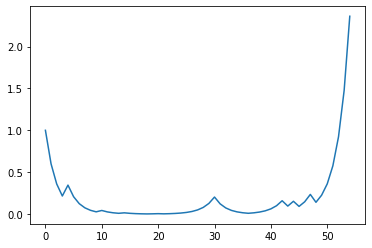

In [9]:
game = exp.play_game(.4, lambda i, v: v >= 2, series=True)['series']
game.plot()
game.iloc[-1]

In [4]:
fs = np.linspace(0, 1, 111)
fs

array([0.        , 0.00909091, 0.01818182, 0.02727273, 0.03636364,
       0.04545455, 0.05454545, 0.06363636, 0.07272727, 0.08181818,
       0.09090909, 0.1       , 0.10909091, 0.11818182, 0.12727273,
       0.13636364, 0.14545455, 0.15454545, 0.16363636, 0.17272727,
       0.18181818, 0.19090909, 0.2       , 0.20909091, 0.21818182,
       0.22727273, 0.23636364, 0.24545455, 0.25454545, 0.26363636,
       0.27272727, 0.28181818, 0.29090909, 0.3       , 0.30909091,
       0.31818182, 0.32727273, 0.33636364, 0.34545455, 0.35454545,
       0.36363636, 0.37272727, 0.38181818, 0.39090909, 0.4       ,
       0.40909091, 0.41818182, 0.42727273, 0.43636364, 0.44545455,
       0.45454545, 0.46363636, 0.47272727, 0.48181818, 0.49090909,
       0.5       , 0.50909091, 0.51818182, 0.52727273, 0.53636364,
       0.54545455, 0.55454545, 0.56363636, 0.57272727, 0.58181818,
       0.59090909, 0.6       , 0.60909091, 0.61818182, 0.62727273,
       0.63636364, 0.64545455, 0.65454545, 0.66363636, 0.67272

Read from cache
CPU times: user 362 ms, sys: 731 ms, total: 1.09 s
Wall time: 1.09 s


Text(0, 0.5, 'Value')

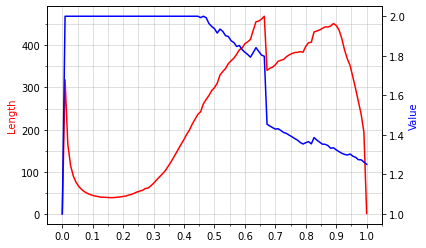

In [112]:
%%time

cache_filename_format = 'data/play/game_fs_{}_{}_{}_{}_{}.pickle'

cache = True
processes = int(mp.cpu_count() - 2)
fs = (0, 1, 111)
simulations = 500_000
stop_mode = 'doubled'

cache_filename = cache_filename_format.format(stop_mode, *fs, simulations)
if cache and os.path.exists(cache_filename):
    with open(cache_filename, 'rb') as f:
        fs, f_lengths, f_values = pickle.load(f)
        print('Read from cache')
else:
    print('Simulating... ({} processes)'.format(processes))
    fs = np.linspace(*fs)
    f_lengths, f_values = exp.simulate(simulations, stop_mode, fs, processes)
    with open(cache_filename, 'wb') as f:
        pickle.dump((fs, f_lengths, f_values), f)
        print('Wrote to cache')
    
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
y1 = [d.mean() for d in f_lengths]
y2 = [min(2, d.mean()) for d in f_values]
ax1.plot(fs, y1, color='red')
ax1.set_ylabel('Length', color='red')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.grid(b=True, which='both', alpha=.5)
ax2.plot(fs, y2, color='blue')
ax2.set_ylabel('Value', color='blue')

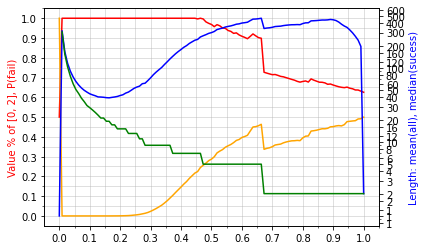

In [183]:
#f_values = [v.clip(upper=2) for v in f_values]
f_values_lengths = list(zip(f_values, f_lengths))

p_wiped = [v[v < .001].size / v.size for v in f_values]
p_fail = [v[v < 2].size / v.size for v in f_values]
value_mean = [min(2, v.mean()) for v in f_values]
value_percentage_mean = [min(2, v.mean())/2 for v in f_values]

length_mean = [l[v >= 0].mean() for v, l in f_values_lengths]
length_median = [l[v >= 2].median() for v, l in f_values_lengths]

# i = 1
# f = fs[i]
# v = f_values[i]
# l = f_lengths[i]
# print('f = {}'.format(f))
# print(v)
# print(l)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
c1 = 'red'
c2 = 'orange'
ax1.plot(fs, value_percentage_mean, color=c1)
ax1.plot(fs, p_fail, color=c2)
# ax1.plot(fs, p_wiped, color=c1)
# ax1.plot(fs, p_fail, color=c2)
# ax1.set_ylabel('P(wiped), P(fail)', color=c1)
ax1.set_ylabel('Value % of [0, 2], P(fail)', color=c1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.grid(b=True, which='both', alpha=.5)
c1 = 'blue'
c2 = 'green'
ax2.plot(fs, length_mean, color=c1)
ax2.plot(fs, length_median, color=c2)
ax2.set_ylabel('Length: mean(all), median(sucess)', color=c1)
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.yaxis.set_major_locator(ticker.LogLocator(subs=(.12, .16, .2, .3, .4, .5, .6, .8, 1)))


26.13636363636363

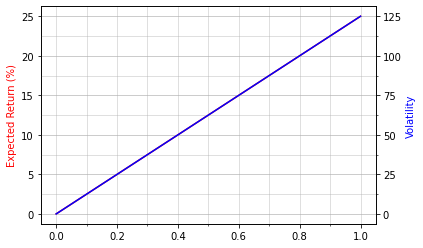

In [180]:
fig, ax1 = plt.subplots()
gain_multiplier = lambda f: 1 - f + f * 2.5
loss_multiplier = lambda f: 1 - f
er_computed = [(.5*gain_multiplier(f) + .5*loss_multiplier(f) - 1)*100 for f in fs]
vol_computed = [(.5*gain_multiplier(f) - .5*loss_multiplier(f))*100 for f in fs]
c1 = 'red'
ax1.plot(fs, er_computed, color=c1)
ax1.set_ylabel('Expected Return (%)', color=c1)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.grid(b=True, which='both', alpha=.5)
ax2 = ax1.twinx()
c2 = 'blue'
ax2.plot(fs, vol_computed, color=c2)
ax2.set_ylabel('Volatility', color=c2)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(25))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.grid(b=True, which='both', alpha=.5)
i = np.where(fs >= .2)[0][0]
vol_computed[i]


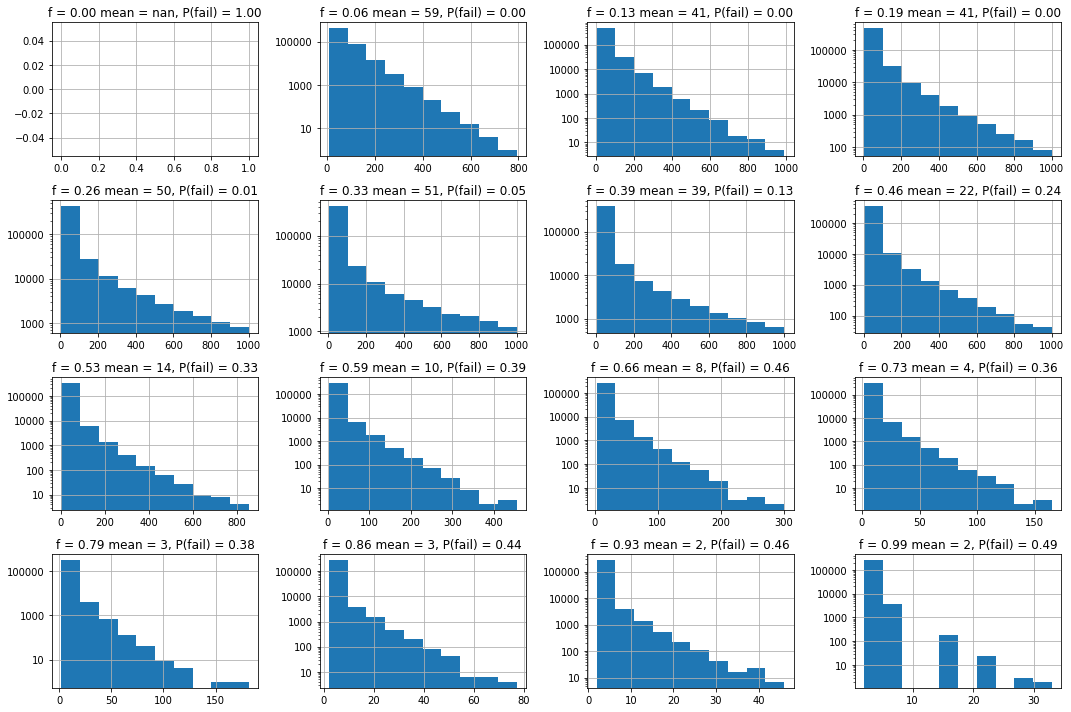

In [188]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
for ax, f in zip(axes.flat, np.linspace(0, 1, len(axes.flat))):
    i = np.where(np.abs(fs - f) < .01)[0][0]
    f = fs[i]
    values = f_values[i]
    lengths = f_lengths[i]
    p_fail = values[values < 2].size / values.size
    #lengths.hist(ax=ax, color='red')
    sublengths = lengths[values >= 2]
    sublengths.hist(ax=ax)
    ax.set_title('f = {:.2f} mean = {:.0f}, P(fail) = {:.2f}'.format(f, sublengths.mean(), p_fail))
    if f > 0:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tight_layout()

<AxesSubplot:>

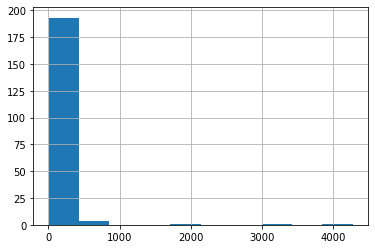

In [964]:
f = .3
durations = []
for i in range(simulations):
    length = exp.play_game(f, stop, result='length', ko_length=penalizer)
    durations.append(length)
durations = pd.Series(sorted(durations))
durations.hist()

In [1007]:
f_durations[0].value_counts()[penalizer]/f_durations[0].size

1.0

In [1005]:
series.count?

Signature: series.count(level=None)
Docstring:
Return number of non-NA/null observations in the Series.

Parameters
----------
level : int or level name, default None
    If the axis is a MultiIndex (hierarchical), count along a
    particular level, collapsing into a smaller Series.

Returns
-------
int or Series (if level specified)
    Number of non-null values in the Series.

See Also
--------
DataFrame.count : Count non-NA cells for each column or row.

Examples
--------
>>> s = pd.Series([0.0, 1.0, np.nan])
>>> s.count()
2
File:      ~/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py
Type:      method


In [998]:
a.count?

Signature: a.count(value, /)
Docstring: Return number of occurrences of value.
Type:      builtin_function_or_method
